In [177]:
import pandas as pd
import numpy as np
from utils import spliter
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pickle

# The ANN architecture:-

In [178]:
import numpy as np
def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z))

def relu(z):
    return np.maximum(0, z)

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)  # numerical stability
    z = np.clip(z, -50, 50)  # limit extreme values
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def relu_derivative(z):
    return (z>0)*1

def linear(z):
    return z

def linear_derivative(z):
    return 1

def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_true-y_pred))

def cross_entropy_loss(y_true, y_pred):
    eps = 1e-15  # avoid log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def activation_decider(activation, z):
  if activation == 'sigmoid':
    return sigmoid(z)
  elif activation == 'relu':
    return relu(z)
  elif activation == 'linear':
    return linear(z)
  elif activation == 'softmax':
    return softmax(z)

def activation_derivative_decider(activation, z):
  if activation == 'sigmoid':
    return sigmoid_derivative(z)
  elif activation == 'relu':
    return relu_derivative(z)
  elif activation == 'linear':
    return linear_derivative(z)

In [179]:
class NeuralNetwork:

    def __init__(self, layers, activations):
        self.layers = layers
        self.activations = activations
        self.weights = []
        self.biases = []

        for i in range(len(layers) - 1):
            # He initialization for ReLU, Glorot otherwise
            if activations[i] == 'relu':
                stddev = np.sqrt(2 / layers[i])  # He initialization
            else:
                stddev = np.sqrt(1 / (layers[i] + layers[i + 1]))  # Glorot/Xavier
            self.weights.append(np.random.randn(layers[i], layers[i + 1]) * stddev)
            self.biases.append(np.zeros((1, layers[i + 1])))

    def forward(self, x):
        z_values = []
        activation_values = [x]

        for i in range(len(self.weights)):
            z = np.dot(x, self.weights[i]) + self.biases[i]
            z_values.append(z)
            x = activation_decider(self.activations[i], z)
            activation_values.append(x)

        return z_values, activation_values

    def backward(self, x, y, activations, z_values, learning_rate):
        m = x.shape[0]
        deltas = []

        # Output layer delta
        if self.activations[-1] == 'softmax':
            delta = activations[-1] - y  # softmax + cross-entropy
        else:
            delta = (activations[-1] - y) * activation_derivative_decider(self.activations[-1], z_values[-1])

        deltas.append(delta)

        # Backpropagate through hidden layers
        for i in reversed(range(len(self.weights) - 1)):
            delta = deltas[-1].dot(self.weights[i + 1].T) * activation_derivative_decider(self.activations[i], z_values[i])
            deltas.append(delta)

        deltas.reverse()

        # Update weights and biases
        for i in range(len(self.weights)):
            a_prev = x if i == 0 else activations[i]
            grad_w = a_prev.T.dot(deltas[i]) / m
            grad_b = np.mean(deltas[i], axis=0, keepdims=True)
            grad_w = np.clip(grad_w, -1.0, 1.0)
            grad_b = np.clip(grad_b, -1.0, 1.0)
            self.weights[i] -= learning_rate * grad_w
            self.biases[i] -= learning_rate * grad_b

    def train(self, x_train, y_train, epochs, learning_rate, x_test, y_test):
        train_acc = {}
        test_acc = {}
        losses = {}
        for epoch in range(epochs):
            z_values, activations = self.forward(x_train)
            self.backward(x_train, y_train, activations, z_values, learning_rate)
            if (epoch + 1)%100 == 0:
                loss = cross_entropy_loss(y_train, activations[-1])
                losses[epoch+1] = loss
                print(f"Epoch {epoch+1}: \nLoss = {loss:.6f}")
                predictions = self.predict(x_train)
                acc = np.mean(predictions == y_train.argmax(axis=1))
                train_acc[epoch+1] = acc
                print(f"Train Accuracy : {acc}")

                predictions = self.predict(x_test)
                acc = np.mean(predictions == y_test.argmax(axis=1))
                test_acc[epoch+1] = acc
                print(f"Test Accuracy : {acc}")

        return train_acc, test_acc, losses

    def predict(self, x):
        _, activations = self.forward(x)
        return np.argmax(activations[-1], axis=1)  # class prediction


# Applying model on CNN_features Data

In [180]:
data = pd.read_csv('utils/filtered_CNN_features_dataset.csv')

data = data.drop(columns=['Unnamed: 0'])

label_encoder = LabelEncoder()
data['2048'] = label_encoder.fit_transform(data['2048'])

data.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,0.266585,1.337187,1.352905,0.100848,1.880685,0.059888,2.773605,0.115643,0.138749,0.056121,...,0.039434,0.071662,0.733759,1.643910,0.041306,1.488236,0.048181,0.247783,0.300232,115
1,0.355948,0.750634,0.909794,0.188214,0.680066,0.221442,3.089571,0.342022,0.087186,0.234741,...,0.093867,0.089694,0.859610,1.764073,0.250430,1.133540,0.004091,0.153542,0.236034,115
2,0.267111,1.015316,1.154480,0.131544,1.066389,0.024949,3.701925,0.145037,0.082419,0.253356,...,0.080086,0.089589,0.663708,1.854499,0.078751,1.240009,0.065222,0.105058,0.227633,115
3,0.260295,0.882900,0.885955,0.106698,2.663052,0.057836,1.854394,0.209269,0.103750,0.149302,...,0.181255,0.182038,0.397535,1.222931,0.007285,0.878194,0.016247,0.110492,0.129523,115
4,0.347203,0.623839,0.817085,0.212599,1.026321,0.176634,2.486715,0.426571,0.345026,0.375072,...,0.267895,0.136346,0.713298,0.978184,0.059828,1.008205,0.042905,0.028597,0.199120,115


In [181]:
x_train, x_test, y_train, y_test = spliter.train_test_spliter(data, target_col='2048', train_size = 0.9)
y_train = y_train.astype(np.float32).reshape(-1, 1)
y_test = y_test.astype(np.float32).reshape(-1, 1)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

onehothotencoder = OneHotEncoder()
y_train = onehothotencoder.fit_transform(y_train).toarray()
y_test = onehothotencoder.transform(y_test).toarray()

/home/mayank/all_work/ML-DL/Face_Identification/Face_Detection/applying_ML_algorithms/utils/spliter.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train = pd.concat([train, train_subset])
/home/mayank/all_work/ML-DL/Face_Identification/Face_Detection/applying_ML_algorithms/utils/spliter.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test = pd.concat([test, test_subset])


### Using 2048 features and all the 158 classes to predict:-

In [182]:
input_size = x_train.shape[1]
num_classes = len(data['2048'].unique())

nn = NeuralNetwork([input_size, 512, 256, 128, num_classes], activations = ['relu', 'relu', 'relu', 'softmax'])
train_acc, test_acc, losses = nn.train(x_train, y_train, epochs=1000, learning_rate=0.1, x_test = x_test, y_test = y_test)

Epoch 100: 
Loss = 1.850254
Train Accuracy : 0.5670076055599266
Test Accuracy : 0.2720156555772994
Epoch 200: 
Loss = 0.390126
Train Accuracy : 0.9525308156307369
Test Accuracy : 0.4207436399217221
Epoch 300: 
Loss = 0.105779
Train Accuracy : 0.998426435877262
Test Accuracy : 0.4344422700587084
Epoch 400: 
Loss = 0.046445
Train Accuracy : 1.0
Test Accuracy : 0.4500978473581213
Epoch 500: 
Loss = 0.027650
Train Accuracy : 1.0
Test Accuracy : 0.4500978473581213
Epoch 600: 
Loss = 0.019120
Train Accuracy : 1.0
Test Accuracy : 0.45401174168297453
Epoch 700: 
Loss = 0.014381
Train Accuracy : 1.0
Test Accuracy : 0.45596868884540115
Epoch 800: 
Loss = 0.011412
Train Accuracy : 1.0
Test Accuracy : 0.45596868884540115
Epoch 900: 
Loss = 0.009396
Train Accuracy : 1.0
Test Accuracy : 0.45596868884540115
Epoch 1000: 
Loss = 0.007947
Train Accuracy : 1.0
Test Accuracy : 0.45596868884540115


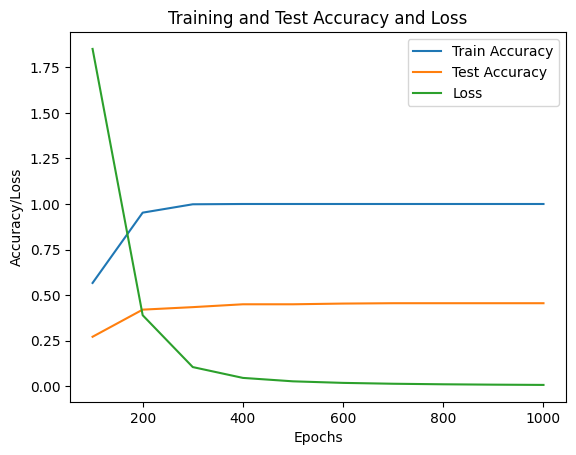

In [183]:
plt.plot(list(train_acc.keys()), list(train_acc.values()), label='Train Accuracy')
plt.plot(list(test_acc.keys()), list(test_acc.values()), label='Test Accuracy')
plt.plot(list(losses.keys()), list(losses.values()), label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.title('Training and Test Accuracy and Loss')
plt.show()

In [184]:
counts = data['2048'].value_counts()
filter_labels = counts[counts > 80].index
data = data[data['2048'].isin(filter_labels)]

x_train, x_test, y_train, y_test = spliter.train_test_spliter(data, target_col='2048', train_size = 0.8)

lda = LDA(n_components=4)
lda.fit(x_train, y_train.astype(np.float32))
x_train_lda = lda.transform(x_train)
x_test_lda = lda.transform(x_test)

y_train = y_train.astype(np.float32).reshape(-1, 1)
y_test = y_test.astype(np.float32).reshape(-1, 1)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

onehothotencoder = OneHotEncoder()
y_train = onehothotencoder.fit_transform(y_train).toarray()
y_test = onehothotencoder.transform(y_test).toarray()

y_train.shape

/home/mayank/all_work/ML-DL/Face_Identification/Face_Detection/applying_ML_algorithms/utils/spliter.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train = pd.concat([train, train_subset])
/home/mayank/all_work/ML-DL/Face_Identification/Face_Detection/applying_ML_algorithms/utils/spliter.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test = pd.concat([test, test_subset])


(910, 5)

### Using 2048 features and 5 classes:-

In [185]:
input_size = x_train.shape[1]
num_classes = len(data['2048'].unique())

nn = NeuralNetwork([input_size, 64, 16, num_classes], activations = ['relu', 'relu', 'softmax'])
train_acc, test_acc, losses = nn.train(x_train, y_train, epochs=1000, learning_rate=0.1, x_test = x_test, y_test = y_test)

Epoch 100: 
Loss = 0.021115
Train Accuracy : 1.0
Test Accuracy : 0.7695652173913043
Epoch 200: 
Loss = 0.006736
Train Accuracy : 1.0
Test Accuracy : 0.782608695652174
Epoch 300: 
Loss = 0.003694
Train Accuracy : 1.0
Test Accuracy : 0.782608695652174
Epoch 400: 
Loss = 0.002436
Train Accuracy : 1.0
Test Accuracy : 0.7913043478260869
Epoch 500: 
Loss = 0.001779
Train Accuracy : 1.0
Test Accuracy : 0.7956521739130434
Epoch 600: 
Loss = 0.001388
Train Accuracy : 1.0
Test Accuracy : 0.7913043478260869
Epoch 700: 
Loss = 0.001130
Train Accuracy : 1.0
Test Accuracy : 0.7913043478260869
Epoch 800: 
Loss = 0.000946
Train Accuracy : 1.0
Test Accuracy : 0.7913043478260869
Epoch 900: 
Loss = 0.000811
Train Accuracy : 1.0
Test Accuracy : 0.7913043478260869
Epoch 1000: 
Loss = 0.000707
Train Accuracy : 1.0
Test Accuracy : 0.7913043478260869


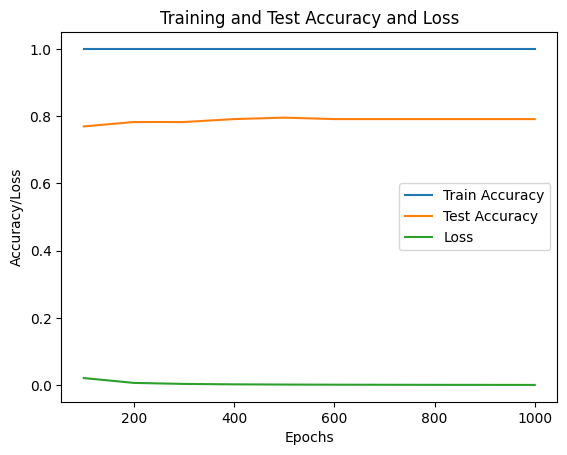

In [187]:
plt.plot(list(train_acc.keys()), list(train_acc.values()), label='Train Accuracy')
plt.plot(list(test_acc.keys()), list(test_acc.values()), label='Test Accuracy')
plt.plot(list(losses.keys()), list(losses.values()), label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.title('Training and Test Accuracy and Loss')
plt.show()

In [ ]:
"""params = {
    "weights" : [w for w in nn.weights],
    "biases" : [b for b in nn.biases],
    "layers" : nn.layers,
    "activation": nn.activations
}

np.save("utils/ann_params.npy", params, allow_pickle=True)"""

'params = {\n    "weights" : [w for w in nn.weights],\n    "biases" : [b for b in nn.biases],\n    "layers" : nn.layers,\n    "activation": nn.activations\n}\n\nnp.save("utils/ann_params.npy", params, allow_pickle=True)'

### Best model parameters which I found uptil now with 80.43% accuracy trained on 2048 features and 5 classes:-

In [188]:
load_params = np.load("utils/ann_params.npy", allow_pickle=True).item()

nn_loaded = NeuralNetwork(load_params["layers"], activations=load_params["activation"])

nn_loaded.weights = load_params["weights"]
nn_loaded.biases = load_params["biases"]

predictions = nn_loaded.predict(x_test)
acc = np.mean(predictions == y_test.argmax(axis=1))
print(f"Test Accuracy : {acc}")

Test Accuracy : 0.8043478260869565


### Using 4 features and 5 classes:-

In [189]:
input_size = x_train_lda.shape[1]
num_classes = len(data['2048'].unique())

nn = NeuralNetwork([input_size, 64, 16, num_classes], activations = ['relu', 'relu', 'softmax'])
train_acc, test_acc, losses = nn.train(x_train_lda, y_train, epochs=1000, learning_rate=0.1, x_test = x_test_lda, y_test = y_test)

Epoch 100: 
Loss = 0.012011
Train Accuracy : 0.9967032967032967
Test Accuracy : 0.782608695652174
Epoch 200: 
Loss = 0.007428
Train Accuracy : 0.9989010989010989
Test Accuracy : 0.782608695652174
Epoch 300: 
Loss = 0.005463
Train Accuracy : 1.0
Test Accuracy : 0.782608695652174
Epoch 400: 
Loss = 0.004292
Train Accuracy : 1.0
Test Accuracy : 0.782608695652174
Epoch 500: 
Loss = 0.003503
Train Accuracy : 1.0
Test Accuracy : 0.7913043478260869
Epoch 600: 
Loss = 0.002960
Train Accuracy : 1.0
Test Accuracy : 0.7913043478260869
Epoch 700: 
Loss = 0.002548
Train Accuracy : 1.0
Test Accuracy : 0.7913043478260869
Epoch 800: 
Loss = 0.002222
Train Accuracy : 1.0
Test Accuracy : 0.7913043478260869
Epoch 900: 
Loss = 0.001969
Train Accuracy : 1.0
Test Accuracy : 0.7913043478260869
Epoch 1000: 
Loss = 0.001764
Train Accuracy : 1.0
Test Accuracy : 0.7913043478260869


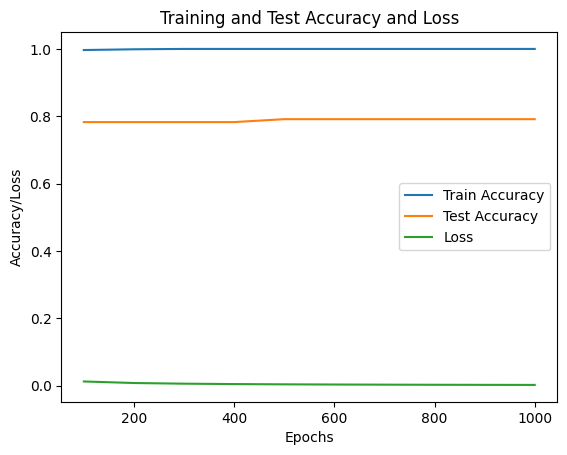

In [190]:
plt.plot(list(train_acc.keys()), list(train_acc.values()), label='Train Accuracy')
plt.plot(list(test_acc.keys()), list(test_acc.values()), label='Test Accuracy')
plt.plot(list(losses.keys()), list(losses.values()), label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.title('Training and Test Accuracy and Loss')
plt.show()

# Applying model on LBP data

In [191]:
data_lbp = pd.read_csv('utils/filtered_LBP_features_dataset.csv')
data_lbp

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,256
0,0,589.0,57.0,319.0,205.0,67.0,4.0,195.0,466.0,370.0,...,474.0,1924.0,612.0,26.0,357.0,592.0,523.0,328.0,6088.0,Tim_Henman
1,1,1012.0,113.0,383.0,203.0,76.0,11.0,205.0,369.0,505.0,...,591.0,2086.0,681.0,29.0,447.0,699.0,535.0,486.0,13472.0,Tim_Henman
2,2,920.0,92.0,288.0,152.0,107.0,18.0,192.0,403.0,313.0,...,461.0,1812.0,579.0,41.0,428.0,597.0,411.0,374.0,11673.0,Tim_Henman
3,3,1068.0,85.0,447.0,298.0,90.0,11.0,293.0,732.0,546.0,...,727.0,2150.0,650.0,32.0,374.0,564.0,585.0,367.0,5449.0,Tim_Henman
4,4,510.0,43.0,304.0,189.0,47.0,8.0,201.0,387.0,296.0,...,405.0,3263.0,588.0,36.0,307.0,593.0,350.0,328.0,4606.0,Tim_Henman
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319,4319,706.0,56.0,472.0,226.0,85.0,6.0,268.0,461.0,325.0,...,539.0,1579.0,513.0,27.0,340.0,430.0,537.0,305.0,9133.0,Pervez_Musharraf
4320,4320,1459.0,118.0,656.0,379.0,130.0,10.0,406.0,572.0,647.0,...,728.0,1208.0,689.0,30.0,374.0,669.0,864.0,332.0,8567.0,Pervez_Musharraf
4321,4321,907.0,103.0,441.0,375.0,104.0,12.0,394.0,887.0,390.0,...,536.0,3389.0,619.0,29.0,356.0,656.0,579.0,353.0,4020.0,Pervez_Musharraf
4322,4322,525.0,44.0,277.0,194.0,49.0,4.0,246.0,456.0,361.0,...,664.0,2049.0,779.0,31.0,643.0,656.0,469.0,515.0,11051.0,Pervez_Musharraf


In [192]:
data_lbp = data_lbp.drop(columns=['Unnamed: 0'])
label_encoder = LabelEncoder()
data_lbp['256'] = label_encoder.fit_transform(data_lbp['256'])

counts = data_lbp['256'].value_counts()
filter_labels = counts[counts > 80].index
data_lbp = data_lbp[data_lbp['256'].isin(filter_labels)]
data_lbp['256'].value_counts()

x_train, x_test, y_train, y_test = spliter.train_test_spliter(data_lbp, target_col='256', train_size = 0.9)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

y_train = y_train.astype(np.float32).reshape(-1, 1)
y_test = y_test.astype(np.float32).reshape(-1, 1)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

onehothotencoder = OneHotEncoder()
y_train = onehothotencoder.fit_transform(y_train).toarray()
y_test = onehothotencoder.transform(y_test).toarray()

/home/mayank/all_work/ML-DL/Face_Identification/Face_Detection/applying_ML_algorithms/utils/spliter.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train = pd.concat([train, train_subset])
/home/mayank/all_work/ML-DL/Face_Identification/Face_Detection/applying_ML_algorithms/utils/spliter.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test = pd.concat([test, test_subset])


In [193]:
input_size = x_train.shape[1]
num_classes = len(data_lbp['256'].unique())

nn = NeuralNetwork([input_size, 64, 16, num_classes], activations = ['relu', 'relu', 'softmax'])
train_acc, test_acc, losses = nn.train(x_train, y_train, epochs=1000, learning_rate=0.1, x_test = x_test, y_test = y_test)

Epoch 100: 
Loss = 0.977303
Train Accuracy : 0.640625
Test Accuracy : 0.5258620689655172
Epoch 200: 
Loss = 0.550384
Train Accuracy : 0.8359375
Test Accuracy : 0.5086206896551724
Epoch 300: 
Loss = 0.248864
Train Accuracy : 0.9501953125
Test Accuracy : 0.46551724137931033
Epoch 400: 
Loss = 0.104260
Train Accuracy : 0.9931640625
Test Accuracy : 0.45689655172413796
Epoch 500: 
Loss = 0.050362
Train Accuracy : 0.998046875
Test Accuracy : 0.4396551724137931
Epoch 600: 
Loss = 0.029684
Train Accuracy : 1.0
Test Accuracy : 0.4396551724137931
Epoch 700: 
Loss = 0.019774
Train Accuracy : 1.0
Test Accuracy : 0.4396551724137931
Epoch 800: 
Loss = 0.014252
Train Accuracy : 1.0
Test Accuracy : 0.4482758620689655
Epoch 900: 
Loss = 0.010910
Train Accuracy : 1.0
Test Accuracy : 0.4482758620689655
Epoch 1000: 
Loss = 0.008733
Train Accuracy : 1.0
Test Accuracy : 0.45689655172413796


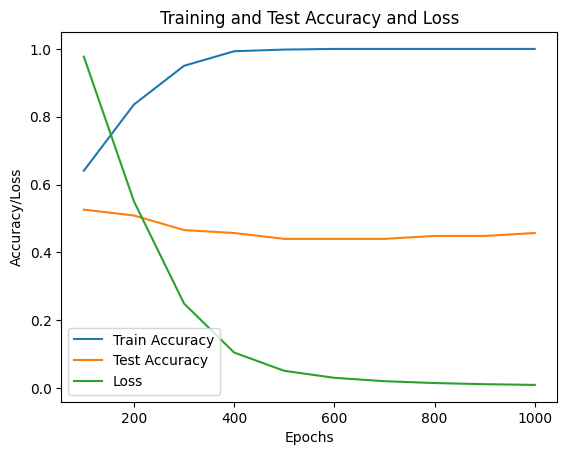

In [195]:
plt.plot(list(train_acc.keys()), list(train_acc.values()), label='Train Accuracy')
plt.plot(list(test_acc.keys()), list(test_acc.values()), label='Test Accuracy')
plt.plot(list(losses.keys()), list(losses.values()), label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.title('Training and Test Accuracy and Loss')
plt.show()

In [ ]:
"""params = {
    "weights" : [w for w in nn.weights],
    "biases" : [b for b in nn.biases],
    "layers" : nn.layers,
    "activation": nn.activations
}

np.save("utils/ann_params_lbp.npy", params, allow_pickle=True)"""

In [196]:
x_train, x_test, y_train, y_test = spliter.train_test_spliter(data_lbp, target_col='256', train_size = 0.8)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

lda = LDA(n_components=4)
lda.fit(x_train, y_train.astype(np.float32))
x_train_lda = lda.transform(x_train)
x_test_lda = lda.transform(x_test)

y_train = y_train.astype(np.float32).reshape(-1, 1)
y_test = y_test.astype(np.float32).reshape(-1, 1)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

onehothotencoder = OneHotEncoder()
y_train = onehothotencoder.fit_transform(y_train).toarray()
y_test = onehothotencoder.transform(y_test).toarray()



/home/mayank/all_work/ML-DL/Face_Identification/Face_Detection/applying_ML_algorithms/utils/spliter.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train = pd.concat([train, train_subset])
/home/mayank/all_work/ML-DL/Face_Identification/Face_Detection/applying_ML_algorithms/utils/spliter.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test = pd.concat([test, test_subset])


In [197]:
input_size = x_train_lda.shape[1]
num_classes = len(data_lbp['256'].unique())

nn = NeuralNetwork([input_size, 64, 16, num_classes], activations = ['relu', 'relu', 'softmax'])
train_acc, test_acc, losses = nn.train(x_train_lda, y_train, epochs=1000, learning_rate=0.1, x_test = x_test_lda, y_test = y_test)

Epoch 100: 
Loss = 0.479042
Train Accuracy : 0.8142857142857143
Test Accuracy : 0.5260869565217391
Epoch 200: 
Loss = 0.454958
Train Accuracy : 0.8197802197802198
Test Accuracy : 0.5391304347826087
Epoch 300: 
Loss = 0.442691
Train Accuracy : 0.823076923076923
Test Accuracy : 0.5347826086956522
Epoch 400: 
Loss = 0.433536
Train Accuracy : 0.8285714285714286
Test Accuracy : 0.5347826086956522
Epoch 500: 
Loss = 0.426084
Train Accuracy : 0.8307692307692308
Test Accuracy : 0.5347826086956522
Epoch 600: 
Loss = 0.419519
Train Accuracy : 0.8340659340659341
Test Accuracy : 0.5347826086956522
Epoch 700: 
Loss = 0.413343
Train Accuracy : 0.8373626373626374
Test Accuracy : 0.5304347826086957
Epoch 800: 
Loss = 0.407694
Train Accuracy : 0.8417582417582418
Test Accuracy : 0.5304347826086957
Epoch 900: 
Loss = 0.402364
Train Accuracy : 0.845054945054945
Test Accuracy : 0.5304347826086957
Epoch 1000: 
Loss = 0.397147
Train Accuracy : 0.8461538461538461
Test Accuracy : 0.5260869565217391


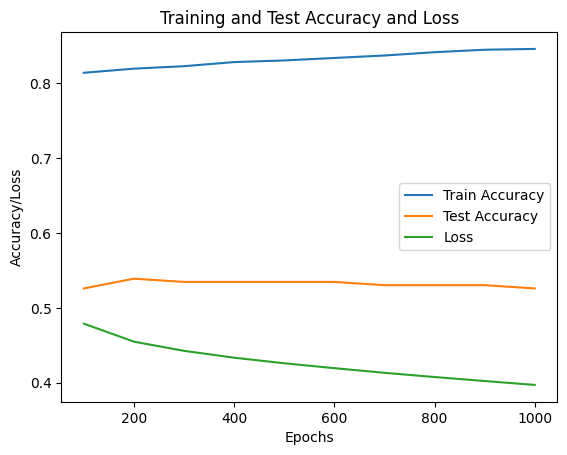

In [198]:
plt.plot(list(train_acc.keys()), list(train_acc.values()), label='Train Accuracy')
plt.plot(list(test_acc.keys()), list(test_acc.values()), label='Test Accuracy')
plt.plot(list(losses.keys()), list(losses.values()), label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.title('Training and Test Accuracy and Loss')
plt.show()